### **Get Data**

In [1]:
# Download & unzip
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00361/data1.zip"
!unzip data1.zip &> /dev/null

--2021-09-24 12:15:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00361/data1.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204012393 (195M) [application/x-httpd-php]
Saving to: ‘data1.zip’

data1.zip           100%[===================>] 194.56M  87.1MB/s    in 2.2s    

2021-09-24 12:15:35 (87.1 MB/s) - ‘data1.zip’ saved [204012393/204012393]



In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset_dir = os.path.join(os.getcwd(), "data1/") # directory of all examples
fdirs = [os.path.join(dataset_dir, i) for i in sorted(os.listdir(dataset_dir))] # list of directories of each example

In [5]:
def get_labeled_data(file_dir):
    '''This function returns recording, gas-label and concentration value for each example'''

    df = pd.read_csv(file_dir, sep='\t', header=None)
    df.columns = ['Time (s)', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']

    def my_floor(a, precision=0):
        return np.round(a - 0.5 * 10**(-precision), precision)

    df["Time (s)"] = my_floor(df["Time (s)"])


    df = df.drop_duplicates(subset = ["Time (s)"]).reset_index(drop=True)

    # Set a standar time-step for all examples
    df.set_index("Time (s)")
    new_index = pd.Index(np.arange(0,600.0,0.1), name="Time (s)")
    df.set_index("Time (s)").reindex(new_index)

    # Handle missing data
    df = df.set_index("Time (s)").reindex(new_index).reset_index().interpolate()

    # Scale all readings to the 0-1 range
    mx = df[df.columns[1:]].max().max()
    mn = df[df.columns[1:]].min().min()
    for col in df[df.columns[1:]]:
        df[col] = (df[col] - mn) / (mx - mn)

    # Use only the first half of each experiment
    features = df[df.columns[1:]].to_numpy()[:3000, :]

    if "_GCO_" in file_dir:
        label = 0     # carbon monoxide
        target_value = int(file_dir.split("_")[-2].split("F")[1]) * 2.5

    elif "_GEa_" in file_dir:
        label = 1     # ethanol
        target_value = int(file_dir.split("_")[-2].split("F")[1]) * 1.25

    elif "_GEy_" in file_dir:
        label = 2     # ethylene
        target_value = int(file_dir.split("_")[-2].split("F")[1]) * 1.25

    elif "_GMe_" in file_dir:
        label = 3     # methane
        target_value = int(file_dir.split("_")[-2].split("F")[1]) * 2.5

    return features, label, target_value

In [6]:
# Collect data
X, y, c = [], [], []
for file_dir in fdirs:
    ar = get_labeled_data(file_dir)
    ar = list(ar)
    X.append(ar[0]) # Features
    y.append(ar[1]) # Labels
    c.append(ar[2]) # Concentration target values
X = np.array(X)
y = np.array(y)
c = np.array(c)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
c_reshaped = c.reshape(c.shape[0], 1)
scaler.fit(c_reshaped)
c_scaled = scaler.transform(c_reshaped)

In [12]:
# Create train, validation and test sets
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y.reshape(y.shape[0], 1), c_scaled, test_size=0.25)
X_train, X_val, y_train, y_val, c_train, c_val = train_test_split(X_train, y_train, c_train, test_size=0.333)

In [13]:
# Data Augmentation
 
import random
 
def gauss_noise(X, sigma=0.001):
    '''Addition of gaussian noise to the extisting time series'''
    
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+noise

noisy_data = gauss_noise(X_train)
noisy_data2 = gauss_noise(noisy_data)

X_train = np.concatenate((X_train, noisy_data, noisy_data2))
y_train = np.concatenate((y_train, y_train, y_train))
c_train = np.concatenate((c_train, c_train, c_train))

In [14]:
print(f"train set shape = {X_train.shape}")
print(f"validation set shape = {X_val.shape}")
print(f"test set shape = {X_test.shape}\n")
 
print(f"train labels shape = {y_train.shape}")
print(f"validation labels shape = {y_val.shape}")
print(f"test labels shape = {y_test.shape}\n")
 
print(f"train targets shape = {c_train.shape}")
print(f"validation targets shape = {c_val.shape}")
print(f"test labels shape = {c_test.shape}")

train set shape = (960, 3000, 8)
validation set shape = (160, 3000, 8)
test set shape = (160, 3000, 8)

train labels shape = (960, 1)
validation labels shape = (160, 1)
test labels shape = (160, 1)

train targets shape = (960, 1)
validation targets shape = (160, 1)
test labels shape = (160, 1)


In [15]:
from tensorflow import keras
from tensorflow.keras.regularizers import l1
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [17]:
# Randomize examples
from sklearn.utils import shuffle
 
X_train, y_train, c_train = shuffle(X_train, y_train, c_train)
X_test, y_test, c_test = shuffle(X_test, y_test, c_test)
X_val, y_val, c_val = shuffle(X_val, y_val, c_val)

In [18]:
# Create a multioutput 1D-CNN

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = Conv1D(filters=32, kernel_size=2, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

out_reg = Dense(1, activation='linear', kernel_regularizer=l1(0.01))(x) # regression output
out_class = Dense(4, activation='softmax', kernel_regularizer=l1(0.01))(x) # classification output

model = Model(inputs=inputs, outputs=[out_reg, out_class])
model.compile(loss=['mse','sparse_categorical_crossentropy'],metrics=['mean_squared_error', 'accuracy'], optimizer=Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000, 8)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 32)     544         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1499, 32)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1498, 32)     2080        max_pooling1d[0][0]              
______________________________________________________________________________________________

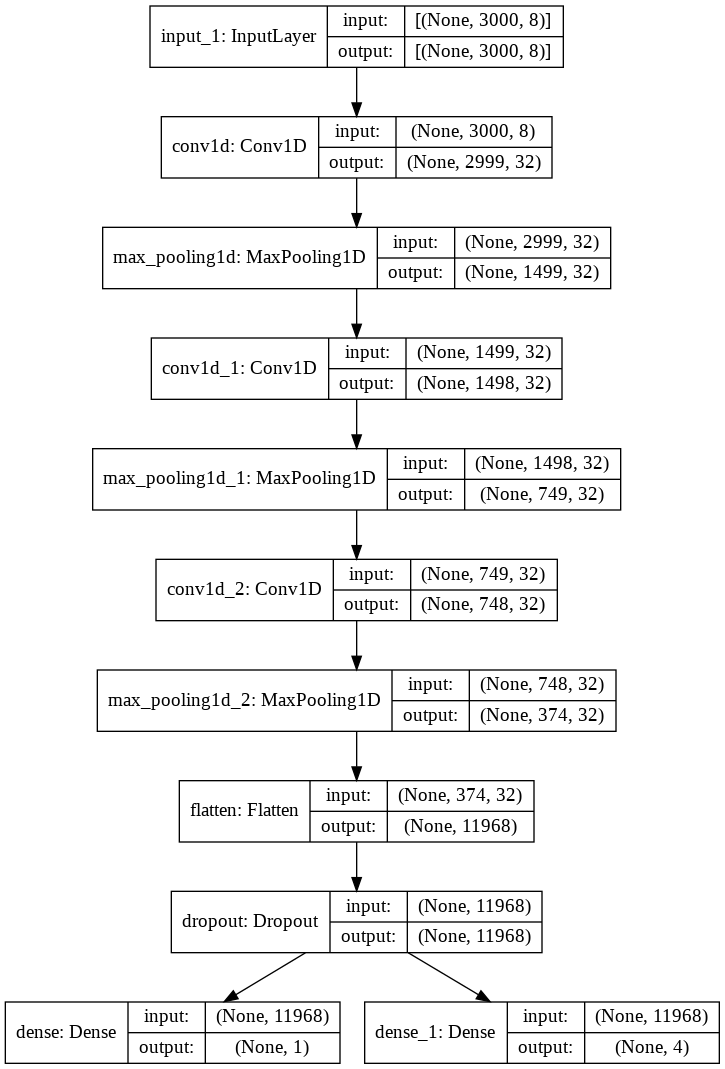

In [20]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
history = model.fit(X_train, [c_train, y_train], validation_data=(X_val, [c_val, y_val]), epochs=100, batch_size=256, verbose=2)

Epoch 1/100
4/4 - 5s - loss: 7.5669 - dense_loss: 0.1906 - dense_1_loss: 1.3743 - dense_mean_squared_error: 0.1906 - dense_accuracy: 0.0406 - dense_1_mean_squared_error: 2.9023 - dense_1_accuracy: 0.3104 - val_loss: 6.2406 - val_dense_loss: 0.0907 - val_dense_1_loss: 1.3558 - val_dense_mean_squared_error: 0.0907 - val_dense_accuracy: 0.0625 - val_dense_1_mean_squared_error: 2.6728 - val_dense_1_accuracy: 0.2375
Epoch 2/100
4/4 - 3s - loss: 5.6704 - dense_loss: 0.1046 - dense_1_loss: 1.3343 - dense_mean_squared_error: 0.1046 - dense_accuracy: 0.0333 - dense_1_mean_squared_error: 2.9030 - dense_1_accuracy: 0.3229 - val_loss: 4.7099 - val_dense_loss: 0.1048 - val_dense_1_loss: 1.3322 - val_dense_mean_squared_error: 0.1048 - val_dense_accuracy: 0.0750 - val_dense_1_mean_squared_error: 2.6734 - val_dense_1_accuracy: 0.3562
Epoch 3/100
4/4 - 3s - loss: 4.2577 - dense_loss: 0.1010 - dense_1_loss: 1.3068 - dense_mean_squared_error: 0.1010 - dense_accuracy: 0.0385 - dense_1_mean_squared_error: 

In [23]:
model.evaluate(X_test, [c_test, y_test], batch_size=batch_size, verbose=1)

1/1 [==============================] - 0s 119ms/step - loss: 0.4994 - dense_loss: 0.0515 - dense_1_loss: 0.1732 - dense_mean_squared_error: 0.0515 - dense_accuracy: 0.0812 - dense_1_mean_squared_error: 2.9226 - dense_1_accuracy: 0.9625


[0.49937668442726135,
 0.05154664069414139,
 0.1731584370136261,
 0.05154664069414139,
 0.08124999701976776,
 2.9225902557373047,
 0.9624999761581421]

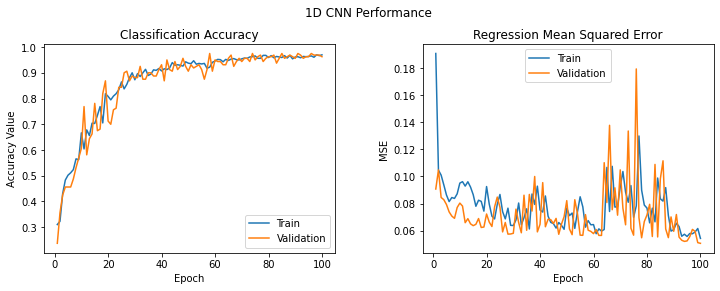

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
 
epoch_list = list(range(1, epochs+1))
history_keys_list = list(history.history.keys())

ax1.plot(epoch_list, history.history[history_keys_list[6]], label='Train')
ax1.plot(epoch_list, history.history[history_keys_list[-1]], label='Validation')
ax1.set_xticks(np.arange(0, epochs+1, epochs // 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Classification Accuracy')
l1 = ax1.legend(loc="best")
 
ax2.plot(epoch_list, history.history[history_keys_list[3]], label='Train')
ax2.plot(epoch_list, history.history[history_keys_list[10]], label='Validation')
ax2.set_xticks(np.arange(0, epochs+1, epochs // 5))
ax2.set_ylabel('MSE')
ax2.set_xlabel('Epoch')
ax2.set_title('Regression Mean Squared Error')
l2 = ax2.legend(loc="best")

In [36]:
predictions = model.predict(X_test)
regress_pred = predictions[0]
class_pred = predictions[1]

In [26]:
regress_pred_rescaled = scaler.inverse_transform(regress_pred)
rescaled_ctest = scaler.inverse_transform(c_test)

In [34]:
# sns.histplot(rescaled_ctest)

In [35]:
# sns.histplot(regress_pred_rescaled)

In [29]:
df = pd.DataFrame({"True Label":y_test.reshape(y_test.shape[0]),
              "Predicted Label":np.argmax(class_pred, axis=1),
              "True ppm":rescaled_ctest.reshape(rescaled_ctest.shape[0]),
              "Predicted ppm":regress_pred_rescaled.reshape(regress_pred_rescaled.shape[0])})

df = df.replace({0:"CO",
                        1:"Ethanol",
                        2:"Ethylene",
                        3:"Methane"})

df_methane = df.loc[df['True Label'] == "Methane"].reset_index(drop=True)
df_co = df.loc[df['True Label'] == "CO"].reset_index(drop=True)
df_ethylene = df.loc[df['True Label'] == "Ethylene"].reset_index(drop=True)
df_ethanol = df.loc[df['True Label'] == "Ethanol"].reset_index(drop=True)

In [45]:
df

,True Label,Predicted Label,True ppm,Predicted ppm
0,Ethylene,Ethylene,37.5,85.884262
1,CO,CO,250.0,98.397888
2,Methane,Methane,250.0,197.221756
3,Ethylene,Ethylene,37.5,83.514854
4,Methane,CO,225.0,99.816132
...,...,...,...,...
155,Ethanol,Ethanol,112.5,68.319511
156,Ethylene,Ethylene,75.0,80.284233
157,Methane,Methane,125.0,143.997559
158,Ethylene,Ethylene,100.0,80.135742


###### As we can see the model has a classification accuracy of 96 %. Nevertheless we need to further investigate the correlation of the physical problem  with the expected output for the regression task. A way to do this is through representation learning/disentanglement in order to construct more accurate representations of the space of the sensory data. We also need to take into account more feratures of the physical problem such as temperature, pressure, the topology characteristics of the sensors in the array (shape, distance from source, etc.) but also the fluid dynamics of the odor delivery system.